# Market Making Strategy with Cryptocurrencies

In this notebook, I will be implementing the market-making methodology outlined in Avellaneda and Stoikov's popular market making whitepaper titled High-Frequency Trading in a Limit Order Book. The paper can be found for free here: https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

In the whitepaper, the optimal behaviour of a market maker given certain assumptions is derived. Ultimately, this derivation yields a spread used to calculate the optimal placement for limit order, which is defined as follows:

$$
\text{bid / ask spread} = \gamma \sigma ^2 (T - t) + \frac{2}{\gamma}\ln\left(1 + \frac{\gamma}{k}\right)
$$

This spread is defined around a reservation price i.e. a price at which a market maker is indifferent between their current portfolio and their current portfolio $\pm$ a new share. The reservation price is derived in the whitepaper as follows:

$$
\text{reservation price} = s - q\gamma\sigma^2(T-t)
$$

The variables mentioned in the above definitions are as follows:

* $s$ i.e. the per-unit mid-price of the
* $T$, the terminus of the time series 
* $\sigma$, the volatility of the asset 
* $q$, the number of assets held in inventory
* $\gamma$, a risk factor that is adjusted to meet the risk/return trade-off of the market maker
* $x$, the initial capital of the market maker
* $k$, the intensity of the arrival of orders


# 0 - Implementation of the Paper

Now that we have an idea of where to start, let us first implement the simulation that is done in the paper, and see if we can translate it directly to the crypo pairs that we picked earlier.

In [66]:
#!pip install pykrakenapi
#!pip install binance
#!pip install powerlaw

In [67]:
# For calculations
import numpy as np
import pandas as pd
import random
from datetime import datetime
import powerlaw
import scipy.optimize

# For Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import matplotlib.dates as mdates

# Save To/Navigate Through System Directory
import sys
import os
import pickle

# For Parallel Computation
from multiprocess import Pool

# Other/APIs
import krakenex
from pykrakenapi import KrakenAPI
import binance

import warnings

warnings.filterwarnings('ignore')

First, we need to define a Brownian Motion generator in order to simulate the mid-price of our asset:

In [68]:
# Create a brownian motion generator
def brownian_motion(x0, n, dt, sigma):

    # Generate normal random variables
    r = np.random.normal(size = n, scale = sigma*np.sqrt(dt))

    # Calculate cumulative sum of random variables
    cumsum = np.cumsum(r)

    # Add in initial conditions
    cumsum += np.expand_dims(x0, axis=-1)
    cumsum[0] = x0
    
    return cumsum

In [69]:
# Set seed for reproducible results
np.random.seed(101)

# Initialize parameters
s0 = 100
T = 1
sigma = 2
dt = 0.005
gamma = 0.1
k = 1.5
A = 140
sim_length = 1000

In [70]:
# Use lists to keep track of results
spreadlist = []
reslist = []
qlist = []

# Duration of each simulation
N = 200

for sim in range(sim_length):
    s = brownian_motion(s0, N+1, dt, sigma)
    
    # Initialize empty array for pnl
    pnl = np.zeros(N+2)
  
    # Inventory
    q = np.zeros(N+2)
    
    # Capital/Cash
    x = np.zeros(N+2)
    
    # Ask limit order
    s_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)
    
    # Bid limit order
    s_b = np.zeros(N+1)

    for i in range(len(s)):
        
        # Calculate reservation price
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)

        # Calculate spread
        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        s_a[i] = s[i] + delta_a
        s_b[i] = s[i] - delta_b
        
        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a) * dt
        lambda_b = A*np.exp(-k*delta_b) * dt

        # Restrict to domain of feasible probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell
        
        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]
        
        # Append results to lists
        spreadlist.append(spread * 2)
        
    reslist.append(pnl[-1])
    qlist.append(q[-1])

To ensure that we have correctly implemented the model, our results should be similar to those in the paper:

<img src="img/AS_results.png" alt="Drawing" style="width: 400px;"/>

In [71]:
pd.DataFrame([np.mean(spreadlist), np.mean(reslist), np.std(reslist), np.mean(qlist), np.std(qlist)],
            index=['Avg. Spread','Profit','Std (Profit)', 'Final $q$', 'Std (Final $q$)'],
            columns=['Inventory']).T

,Avg. Spread,Profit,Std (Profit),Final $q$,Std (Final $q$)
Inventory,1.49077,65.308775,6.605462,0.1,2.989314


I believe that these results are sufficiently close to assume that the strategy was implemented properly. Let's take a peek at some visualizations:

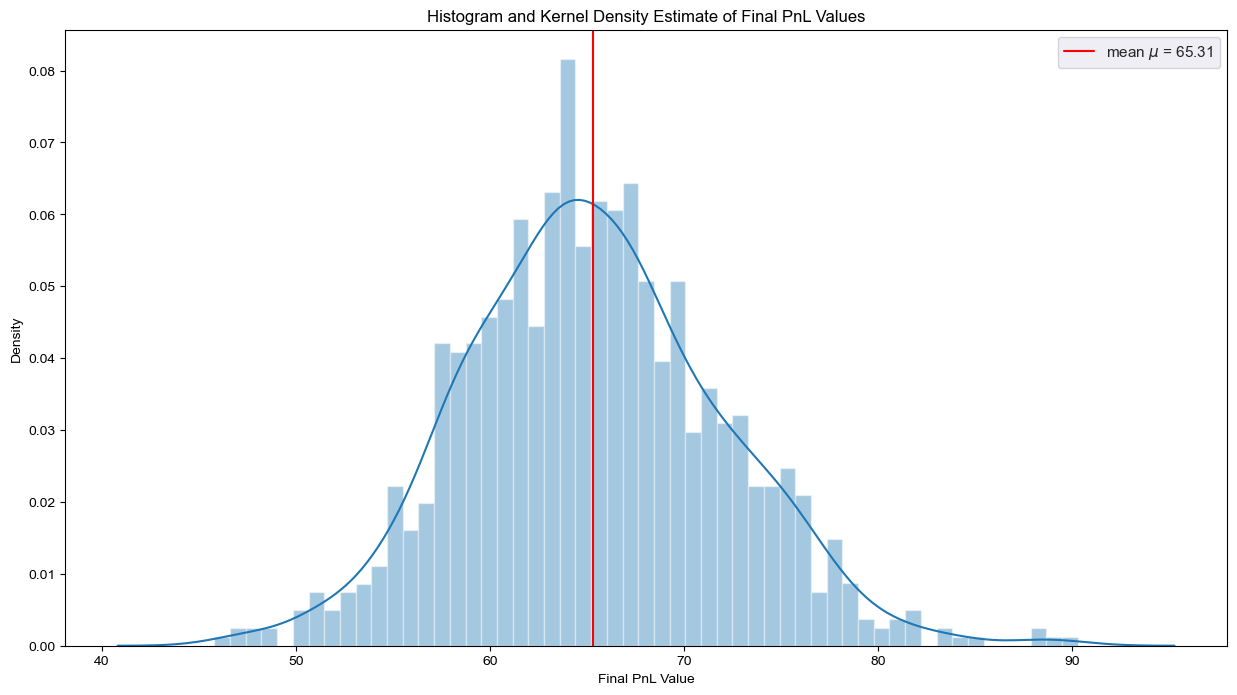

In [72]:
plt.figure(figsize=(15,8))

plt.title('Histogram and Kernel Density Estimate of Final PnL Values')

# Set plot style
sns.set()

# Plot kernel density estimate with normalized histogram
sns.distplot(reslist,bins=55)

plt.axvline(x=np.mean(reslist),
            color='red', label='mean $\mu$ = '+str(np.round(np.mean(reslist),2)))

plt.legend()
plt.ylabel('Density')
plt.xlabel('Final PnL Value')

plt.show()

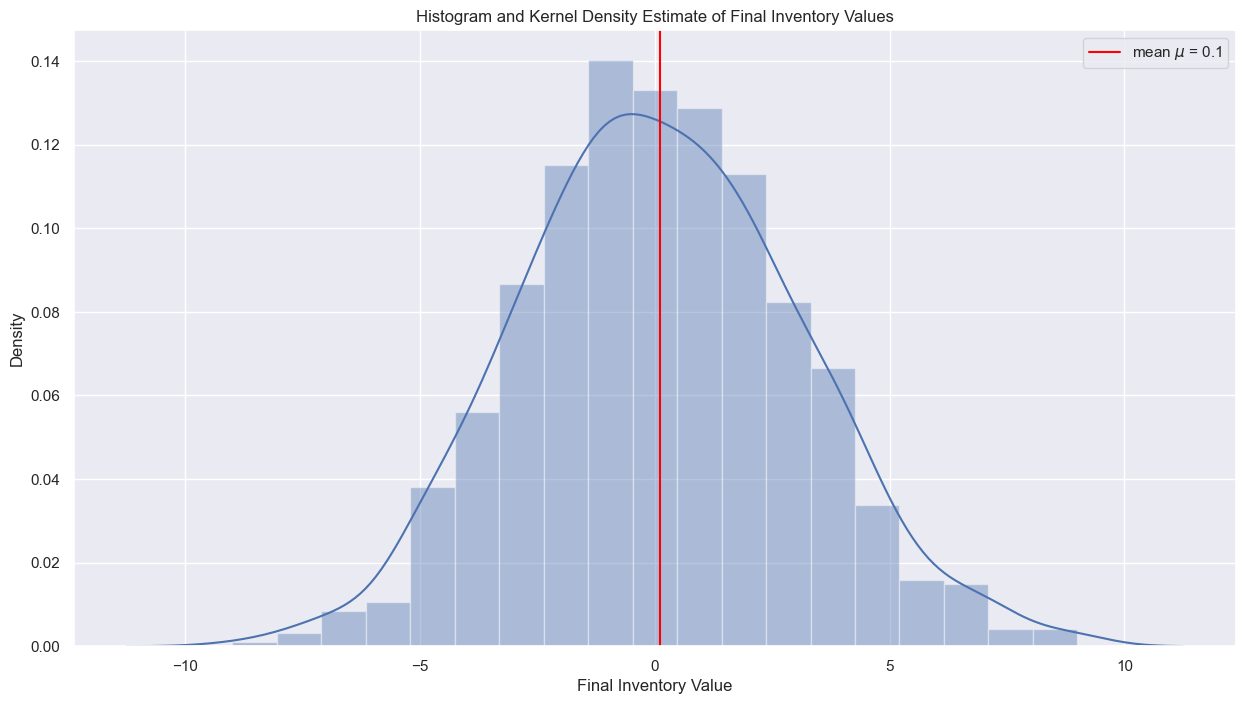

In [73]:
plt.figure(figsize=(15,8))

plt.title('Histogram and Kernel Density Estimate of Final Inventory Values')

# Set plot style
sns.set()

# Plot kernel density estimate with normalized histogram
sns.distplot(qlist,bins=19)

plt.axvline(x=np.mean(qlist),
            color='red', label='mean $\mu$ = '+str(np.round(np.mean(qlist),2)))

plt.legend()
plt.ylabel('Density')
plt.xlabel('Final Inventory Value')

plt.show()

Now, let's move onto some visualizations of a single simulation to see what's going on behind the scenes:

In [74]:
# Combine all our results into a single DataFrane
res = pd.DataFrame([s_a, s, s_b], index=['sell limit orders', 'mid price', 'buy limit orders']).T

res['sells']  = ((pd.Series(q).diff() < 0)[:-1] * s_a).replace(0,np.nan)
res['buys']   = ((pd.Series(q).diff() > 0)[:-1] * s_b).replace(0,np.nan)

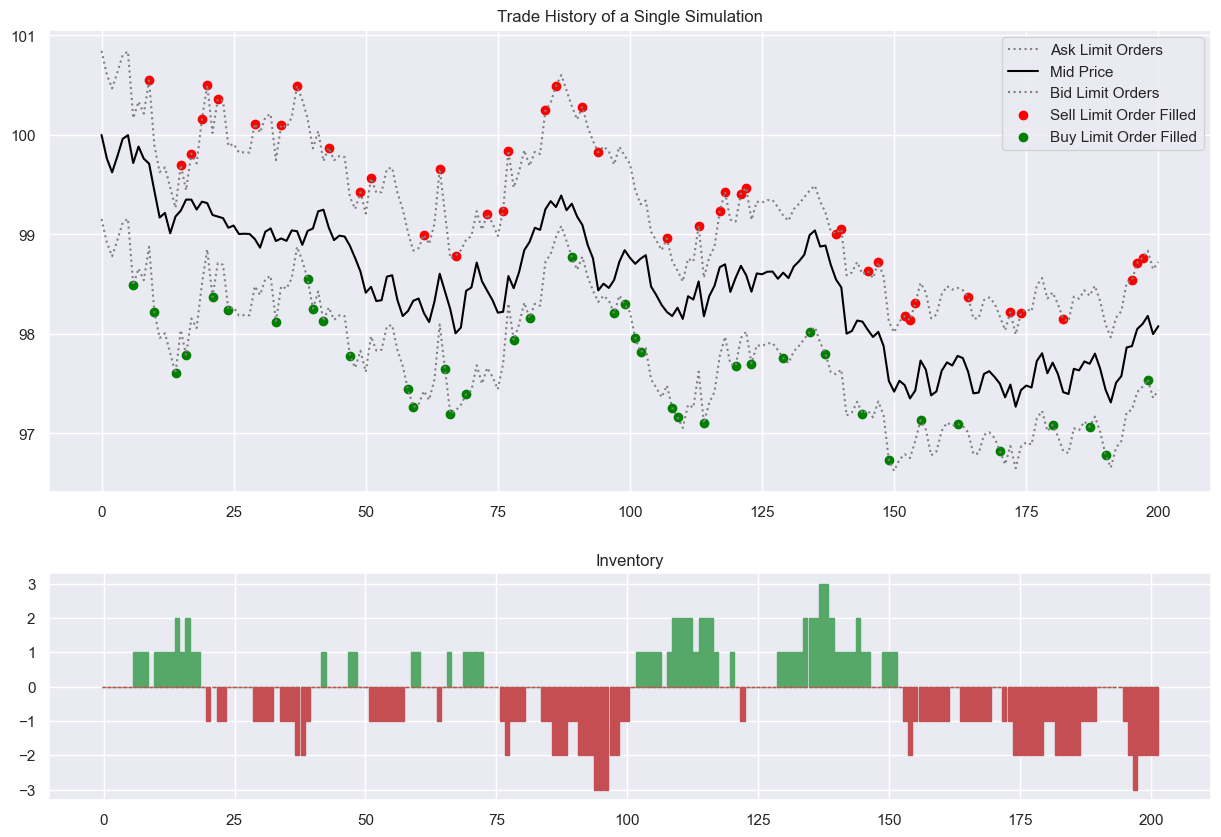

In [75]:
fig = plt.figure(figsize=(15,10))

spec = gridspec.GridSpec(ncols=1, nrows=2, wspace=0.5,
                         hspace=0.5, height_ratios=[3, 1])

fig.add_subplot(spec[0])

# Plot limit orders and mid price
plt.plot(res.iloc[:,0], color='grey',  label='Ask Limit Orders', ls=':')
plt.plot(res.iloc[:,1], color='black', label='Mid Price')
plt.plot(res.iloc[:,2], color='grey',  label='Bid Limit Orders', ls=':')

# Add buys and sells
plt.scatter(range(201), res.iloc[:,3], color='red', label='Sell Limit Order Filled')
plt.scatter(range(201), res.iloc[:,4], color='green', label='Buy Limit Order Filled')

plt.legend()
plt.title('Trade History of a Single Simulation')

fig.add_subplot(spec[1])

plt.subplot(3,1,3)
plt.bar(range(len(q)), q*(q>0), color='g', edgecolor='g')
plt.bar(range(len(q)), q*(q<0), color='r', edgecolor='r')
plt.title('Inventory')

plt.show()

# 1 - Ethereum

Now that we are comfortable with the Avellaneda-Stoikov model, let's source some crypto market/order book data so that we can apply the model to the crypto markets! We will first start with a large-cap crypto with lots of liquidity since data is more freely available. 

## 1.1 - Data

Naturally, the first thing we need to do is source data. The crypto industry is extremely generous with their data, so getting price data is quite easy and is often free.

### 1.1.1 - Kraken Market Data

Kraken makes it very easy to download .csv files of their market order data, and also provide a REST API. Since there are limitations to the data that can be downloaded via the API, we will first work with the .csv files and if time permits, create an algorithm that extracts the data that we want. 

First, let's look at ETH/USD. Since these files are extremely large, they will be kept in a separate folder.

In [76]:
temp = pd.read_csv('./ETHUSD.csv', header=None)
temp.head() 

,0,1,2
0,1438956205,3.00000,70.317378
1,1438956209,3.00000,11.539900
2,1438967962,3.00001,1.073291
3,1438967962,3.00000,41.000000
4,1439016198,3.00000,0.400000


Now, we know from the Kraken website that the data is formatted as follows:

* Date
* Asset Price
* Volume Exchanged

So let's properly name these columns to make the code a little more readable:

In [77]:
temp.columns = ['Timestamp', 'Price', 'Volume']
temp.head()

,Timestamp,Price,Volume
0,1438956205,3.00000,70.317378
1,1438956209,3.00000,11.539900
2,1438967962,3.00001,1.073291
3,1438967962,3.00000,41.000000
4,1439016198,3.00000,0.400000


Now, let's look at each column individually to get a sense of how they are formatted/distributed:

In [78]:
# Look at dates first
dates = temp['Timestamp']

In [79]:
# Are there any NaNs? 
dates.isnull().sum()

0

In [80]:
# Pick an individual date to see how it is formatted
single_date = dates[0]
single_date

1438956205

These numbers are certainly Unix-formatted. Let's convert one to standard date/time format and verify:

In [81]:
pd.to_datetime(single_date, unit='s')

Timestamp('2015-08-07 14:03:25')

The price at this time should be equal to the price in this dataset. We can verify this by comparing to data from another service provider, CoinMarketCap:

<img src="img/ETH_price.png" alt="Drawing" style="width: 800px;"/>

In [82]:
# Verify that the price is within the price range on that date
temp['Price'][0]

3.0

The price is consistent with our third-party verification, so I feel comfortable converting the Date column to human-readable format (for the sake of readability). 

In [83]:
temp['Timestamp'] = pd.to_datetime(temp['Timestamp'], unit='s')
temp.tail()

,Timestamp,Price,Volume
45605419,2023-09-30 23:58:34,1671.58,2.558968
45605420,2023-09-30 23:58:34,1671.58,0.019664
45605421,2023-09-30 23:58:39,1671.00,0.013112
45605422,2023-09-30 23:58:39,1671.00,0.133188
45605423,2023-09-30 23:58:56,1671.01,0.056544


In [84]:
# Set timestamp as the index for the temp DataFrame
temp = temp.set_index('Timestamp')
temp.tail()

,Price,Volume
Timestamp,,
2023-09-30 23:58:34,1671.58,2.558968
2023-09-30 23:58:34,1671.58,0.019664
2023-09-30 23:58:39,1671.00,0.013112
2023-09-30 23:58:39,1671.00,0.133188
2023-09-30 23:58:56,1671.01,0.056544


We can see that some timestamps show up more than once. Naturally, this means that there is more than one transaction-per-second. This is just something to keep in mind for our model. Now, let's move onto price:

In [85]:
pd.DataFrame(temp['Price'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Price,45605424.0,1499.434374,1212.919467,0.15,337.2,1308.71,2305.97,4867.0


Everything looks good here. We verified that the price data does indeed make sense, so without going into extremely granular detail, I think it's safe to move on to volume:

In [86]:
pd.DataFrame(temp['Volume'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Volume,45605424.0,3.748149,18.698464,0.0,0.052522,0.446668,2.13704,6857.221051


Considering each observation is meant to represent a trade/transaction, there shouldn't be any volume values equal to zero. Let's take a closer look:

Since there are only 2 of these observations, let's remove them--they don't make any sense (a trade executing but exchanging 0 shares?)

In [87]:
temp = temp[temp['Volume'] != float(0)]
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,45605422.0,1499.434411,1212.919481,1.500000e-01,337.200000,1308.710000,2305.97000,4867.000000
Volume,45605422.0,3.748149,18.698465,1.000000e-08,0.052522,0.446668,2.13704,6857.221051


In [89]:
# Save to .csv
temp['2021-04-07':'2021-04-20'].to_csv('save/ETH_mkt.csv')

Now, the distribution of volume makes more sense. I'm weary of that 1e-08 number, but as far as I know, such small transactions are feasible. Therefore, I will keep it in the dataset. 

### 1.1.2 Order Book Data

Luckily, I was able to source order book data for some cryptos at the following link: 

https://www.kaggle.com/martinsn/starter-high-frequency-bitcoin-forecasting/notebook

Included in the dataset are Cardano (ADA), Bitcoin (BTC), and Ether/Ethereum (ETH). We will examine the ETH dataset:

In [90]:
ETH_mid = pd.read_csv('./ETH_1sec.csv')
ETH_mid.head() 

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:32:50.861733+00:00,1970.985,0.15,0.000000,0.000000,-0.000038,-0.000495,-0.000500,-0.000632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:32:51.861733+00:00,1970.985,0.15,0.000000,0.000000,-0.000038,-0.000495,-0.000500,-0.000632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:32:52.861733+00:00,1970.985,0.15,0.000000,0.000000,-0.000038,-0.000495,-0.000500,-0.000632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:32:53.861733+00:00,1970.985,0.15,0.000000,0.000000,-0.000038,-0.000495,-0.000500,-0.000632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:32:54.861733+00:00,1971.135,0.03,5832.007602,1.962869,-0.000008,-0.000571,-0.000576,-0.000601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We only really need the system_time and midpoint columns for now, so let's clean those up:

In [91]:
ETH_mid['system_time'] = pd.to_datetime(ETH_mid['system_time'])
ETH_mid = ETH_mid.loc[:,['system_time', 'midpoint']]

In [92]:
# Get a list of all the dates in which we have market data
list_of_dates = ETH_mid['system_time'].dt.date.unique().tolist()

In [93]:
# Change index to the timestamp
ETH_mid = ETH_mid.set_index('system_time')
ETH_mid.head()

,midpoint
system_time,
2021-04-07 11:32:50.861733+00:00,1970.985
2021-04-07 11:32:51.861733+00:00,1970.985
2021-04-07 11:32:52.861733+00:00,1970.985
2021-04-07 11:32:53.861733+00:00,1970.985
2021-04-07 11:32:54.861733+00:00,1971.135


Now, this may not be completely proper, but for the sake of this project, I will need to remove the miliseconds in order for the data to properly align with the Kraken dataset. **Under normal circumstances this would be bad to do.**

In [94]:
ETH_mid.index = pd.to_datetime(ETH_mid.index.strftime('%Y-%m-%d %H:%M:%S'))
ETH_mid.head()

,midpoint
system_time,
2021-04-07 11:32:50,1970.985
2021-04-07 11:32:51,1970.985
2021-04-07 11:32:52,1970.985
2021-04-07 11:32:53,1970.985
2021-04-07 11:32:54,1971.135


In [95]:
# Check if there are any missing seconds
len(ETH_mid) == len(ETH_mid.resample('S').asfreq())

False

In [96]:
# Fill in the gaps with the previos value
ETH_mid = ETH_mid.resample('S').ffill()

## 1.2 - Implementation of A-S to Ethereum Data

The first step of an implementation is to move away from simulating market orders. Now, we can use real market data to do a backtest, so let's define a function that we will use to run our backtests. 

For now, we will assume that all our orders of size 1 get filled. It is important to keep track of any biases that may arrive so we also need to assume that our order gets filled first, and fully filled.

In [97]:
def run_backtest(s, m, gamma, A, k, sigma):
    
    N = 60*60*24
    T = 1
    dt = T/N

    # Initialize empty array for pnl
    pnl = np.zeros(N+1)

    # Inventory
    q = np.zeros(N+1)

    # Capital
    x = np.zeros(N+1)
    
    # Spread
    spr = np.zeros(N+1)

    # Ask limit orders
    r_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)

    # Bid limit orders
    r_b = np.zeros(N+1)
     
    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)

    # Iterate through each second
    for i in range(len(s)):
        
        # Find the date for the given iteration
        date = s.index[i]
        
        # Calculate our reservation price
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
        
        # Calculate our spread
        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        spr[i] = spread
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])
    
        # Define the distance between r[i] and our limit orders
        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap
            
        # Define our limit orders
        r_a[i] = r[i] + delta_a
        r_b[i] = r[i] - delta_b
        
        # Do not buy or sell unless we get a feasible market order
        sell = 0
        buy  = 0

        # If a market order is higher than our ask price, sell 1 unit
        if hi_mkt.loc[:,'Price'].values[i] > r_a[i]:
            sell = 1

        # If a market order is lower than our bid price, buy 1 unit
        if low_mkt.loc[:,'Price'].values[i] < r_b[i]:
            buy = 1

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        #     # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        #     # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    return {'pnl':pnl, 'x':x, 'q':q, 'spread':spr, 'r':r, 'r_a':r_a, 'r_b':r_b}

### 1.2.1 -  Parameter Estimation Methodology

The final piece of the puzzle required for the implementation of the A-S model is the parameter estimation. For this, we will go through the methodology one parameter at a time. Since our mid-price data begins on April 7, 2021, we will pick that day to calculate our initial parameters and walk through our estimation methodology:

In [ ]:
day = '2021-04-07'
temp.loc[day]

#### 1.2.1.1 Estimation of Volatility, $\sigma$

One of the most important measures of an asset is its volatility. Under the assumptions of the model, $\sigma$ is the diffusion factor of a Brownian Motion. Therefore, once we are given price data, we can develop a naive estimate of an asset's $\sigma$ by calculating the standard deviation of the previous days' price movements.  we use log-returns to calculate volatility i.e. 

$$
\begin{aligned}
\text{Log Return} &= \ln\left(\frac{p_t}{p_{t-1}}\right) = \ln\left(p_t\right) - \ln\left(p_{t-1}\right)\\
\\
\Rightarrow \sigma &= \frac{\sqrt{\sum\ln^2 \left(\frac{S_{i+1}}{S_i}\right)}}{\sqrt{N-1}} \sqrt{60\cdot60\cdot24}\\
\end{aligned}
$$

where the coefficient comes from the fact that there are 60 seconds per minute, 60 minutes per hour, 24 hours per $T=1$ day. The application of this is as follows:

In [ ]:
prices = temp.loc[day, 'Price']
prices

In [ ]:
# Recreate the calculations shown above
log_norm = np.log(prices).diff().dropna()
sigma = log_norm.std() * np.sqrt(60*60*24)
sigma

Now that we know how to solve for $\sigma$, let's find the $\sigma$'s for all feasible days, and calculate a 5-day moving average to smooth out the process a little in case of an outlier:

In [34]:
# Calculate the stds
std = (np.log(temp.loc[:,'Price']).diff() # Difference the log prices
                                  .dropna() # Remove any NaNs
                                  .groupby(pd.Grouper(freq='1D')).std() # Calculate the std for each day
                                  .rolling('7D').mean()) # Compute the rolling 7-D average of these

# Scale accordingly
std = std * np.sqrt(60*60*24)
std

Timestamp
2015-08-07     0.000980
2015-08-08    82.242284
2015-08-09    82.242284
2015-08-10    82.242284
2015-08-11    60.746097
                ...    
2023-09-26     0.043646
2023-09-27     0.042819
2023-09-28     0.043168
2023-09-29     0.046206
2023-09-30     0.048237
Freq: D, Name: Price, Length: 2977, dtype: float64

In [35]:
# Combine all the results into a single list
sigmalist = [std[d.strftime('%Y-%m-%d')] for d in list_of_dates]
sigmalist

[0.05502268091856959,
 0.05372964921270468,
 0.053188461183279766,
 0.050691240661882714,
 0.04956186601647773,
 0.0514890238342001,
 0.05038605223618619,
 0.05069389083440191,
 0.051845935925207635,
 0.05409234186163478,
 0.06942669871988483,
 0.10066567725867692,
 0.10135468878197727]

In [39]:
# Save so that we do not always need to recalculate
pd.DataFrame(sigmalist).to_csv('./save/ETH_sigmalist.csv')

In [98]:
sigmalist = pd.read_csv('./save/ETH_sigmalist.csv', header=None)[1][1:].tolist()

#### 1.2.1.2 Estimation of $A$ and $k$

Next, we will need to estimate the coefficients responsible for characterizing the liquidity of the asset (see Dealing with the Inventory Risk here: https://arxiv.org/pdf/1105.3115.pdf) where

$$
\lambda(\delta) = A e^{-\kappa\delta}
$$

To assist us with this parameters estimation, we will be following the method outlined by Sophie Laruelle's paper which can be found here: 

http://events.chairefdd.org/wp-content/uploads/2013/06/CAHIER_MICRO_1.pdf 

as well as a very well-written stackexchange post by Charles-Albert Lehalle found here: 

https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem

The idea behind this estimation method is as follows:

1. Define a range of gaps from the mid price ($\delta$)
2. For each delta, place a limit buy/sell order at the asset mid price $\pm\delta$
3. Using the market data, calculate how long it takes for these limit orders to theoretically be filled ($\delta_t$)
4. Form a histogram of the $\delta_t$ for each $\delta$, they should form a nice exponential distribution
5. Calculate the empirical exponential parameter $\lambda$ for this distribution for each $\delta$
6. These $\lambda$ parameters themselves follow an exponential distribution--solve for the parameters of this distribution to get $A$, $k$

This sounds very complicated, but we will work through it step-by-step:

In [41]:
# Use a single day as an example to start
sample = ETH_mid.loc[day]
sample.index = pd.to_datetime(sample.index)
sample.head()

,midpoint
system_time,
2021-04-07 11:32:50,1970.985
2021-04-07 11:32:51,1970.985
2021-04-07 11:32:52,1970.985
2021-04-07 11:32:53,1970.985
2021-04-07 11:32:54,1971.135


In [42]:
# Define our list of gaps from mid price, delta
deltalist = np.linspace(0.1,1,10)

# Define our limit order placement for the first delta
sample['bid'] = sample['midpoint'] - deltalist[0]
sample['ask']  = sample['midpoint'] + deltalist[0]

sample.head()

,midpoint,bid,ask
system_time,,,
2021-04-07 11:32:50,1970.985,1970.885,1971.085
2021-04-07 11:32:51,1970.985,1970.885,1971.085
2021-04-07 11:32:52,1970.985,1970.885,1971.085
2021-04-07 11:32:53,1970.985,1970.885,1971.085
2021-04-07 11:32:54,1971.135,1971.035,1971.235


In [43]:
# Get the market transactions for the same day, pull same times as sample
mkt_sample = temp.loc[day][sample.index[0]:]['Price']
mkt_sample.tail()

Timestamp
2021-04-07 23:59:47    1960.00
2021-04-07 23:59:47    1960.00
2021-04-07 23:59:49    1960.17
2021-04-07 23:59:49    1961.06
2021-04-07 23:59:52    1961.94
Name: Price, dtype: float64

Recall that there can be more than one market order in a one-second increment. Therefore, we can determine if an ask limit order is filled by considering the max market order that happened in a given one-second increment. Consider the following case:

In [44]:
two_orders = mkt_sample.iloc[-3:-1]
two_orders

Timestamp
2021-04-07 23:59:49    1960.17
2021-04-07 23:59:49    1961.06
Name: Price, dtype: float64

We can see here that two transactions occurred in this one-second interval, so if the maximum market order (\$1961.06) is greater than our ask limit order, then we consider the order as 'filled.' This applies also to buy limit orders, but instead we consider the maximum order in a given one-second interval. 

In [45]:
sample.loc['2021-04-07 23:59:49']

midpoint    1960.195
bid         1960.095
ask         1960.295
Name: 2021-04-07 23:59:49, dtype: float64

We can see here that our ask limit order (1960.295) is priced cheaper than the highest market order (1961.06) therefore, we consider that limit order to be filled. Let's try to formulate this now into code:

In [46]:
# Only need the minimum value for each 1s interval to determine if 
# a market order filled
(two_orders.groupby(pd.Grouper(freq='1S')) # Group by second-increments
           .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask'])) # Determine if any value is 
                                                                    # greater than limit ask

Timestamp
2021-04-07 23:59:49    True
Freq: S, Name: Price, dtype: bool

In [47]:
# Do this for all
bid_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                 .apply(lambda x: np.max(x) < sample.loc[x.name, 'bid']))


ask_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask']))

In [48]:
# Combine the two into a single signal
limit_order_hit = bid_limit_order_hit | ask_limit_order_hit
limit_order_hit

Timestamp
2021-04-07 11:32:50     True
2021-04-07 11:32:51     True
2021-04-07 11:32:52     True
2021-04-07 11:32:53    False
2021-04-07 11:32:54    False
                       ...  
2021-04-07 23:59:48    False
2021-04-07 23:59:49     True
2021-04-07 23:59:50    False
2021-04-07 23:59:51    False
2021-04-07 23:59:52     True
Freq: S, Name: Price, Length: 44823, dtype: bool

In [49]:
# Sanity check
limit_order_hit.sum() > bid_limit_order_hit.sum()

True

In [50]:
# Sanity check
limit_order_hit.sum() > ask_limit_order_hit.sum()

True

Calculate the duration it takes for a market order to fill a limit order:

In [51]:
times = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

We know that the maximum likelihood estimator of $\lambda$ for a Poisson distribution is the 1/sample mean therefore:

In [52]:
lambda_01 = 1/times.mean()
lambda_01

0.21978046495024764

Now, let's extend this to each value in our deltalist:

In [53]:
deltalist = np.linspace(0.1,1,10)

# For some reason, linspace will add very far our decimals
deltalist = [np.round(x,1) for x in deltalist]

deltadict = {}

for price_delta in deltalist:
    print(price_delta)
    sample['bid'] = sample['midpoint'] - price_delta
    sample['ask']  = sample['midpoint'] + price_delta
    
    bid_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                     .apply(lambda x: np.max(x) < sample.loc[x.name, 'bid']))

    ask_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                     .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask']))
    
    # Combine the two into a single signal
    limit_order_hit = bid_limit_order_hit | ask_limit_order_hit
    
    deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
    
    deltadict[price_delta] = deltas

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


Now that we've calculated these time gaps, we can get an idea of how they are distributed. Let's consider the time gaps associated with placing limit order \$0.10 away from the mid price:

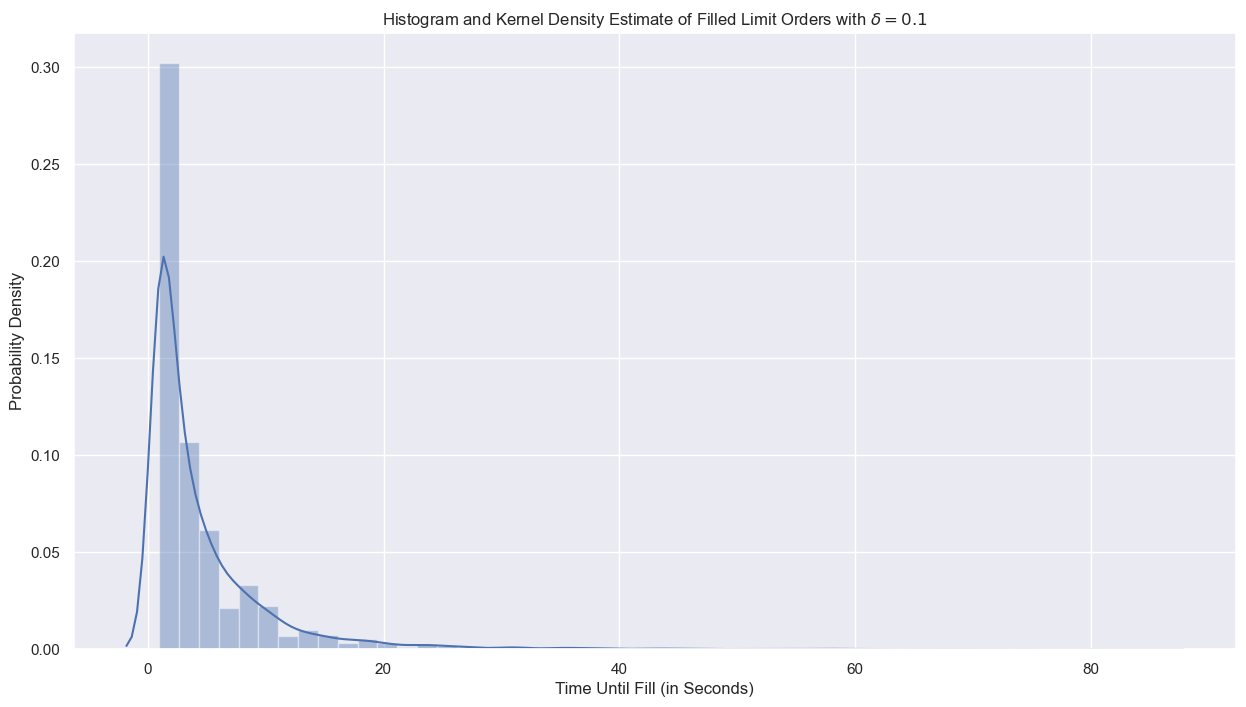

In [54]:
plt.figure(figsize=(15,8))
plt.title('Histogram and Kernel Density Estimate of Filled Limit Orders with $\delta=0.1$')
sns.distplot(deltadict[0.1].dropna())
plt.xlabel('Time Until Fill (in Seconds)')
plt.ylabel('Probability Density')
plt.show()

Now, for each $\delta$ that we have defined, there exists a distribution similar to the one above. Therefore, for each $\delta$, we can calculate the mean waiting time until an order is filled, and get a respective $\lambda_\delta$. By doing exactly this, we can create the chart shown below, which seems to match the chart in Sophie Laruelle's paper quite nicely. 

In [55]:
lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
lambdas

,lambda_delta
delta,
0.1,0.219780
0.2,0.198162
0.3,0.177324
0.4,0.158980
0.5,0.142455
0.6,0.127572
0.7,0.113474
0.8,0.100732
0.9,0.088290


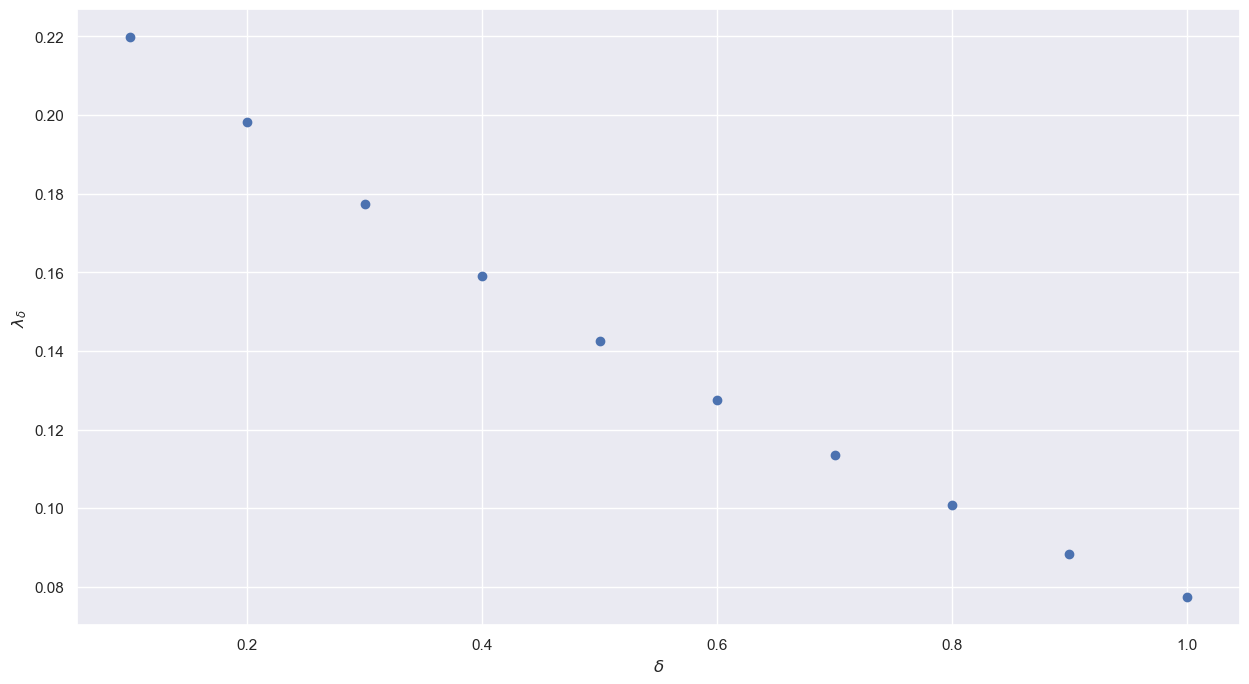

In [56]:
plt.figure(figsize=(15,8))
plt.scatter(lambdas.index, lambdas.values)
plt.xlabel('$\delta$')
plt.ylabel('$\lambda_\delta$')
plt.show()

Now that we have this curve, we can fit an exponential distribution to it:

In [136]:
# Define a function of the expnential curve we are trying to fit
def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y

In [58]:
# Fit the curve to our set of lambdas
paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas['lambda_delta'].values))
A, k = paramsB

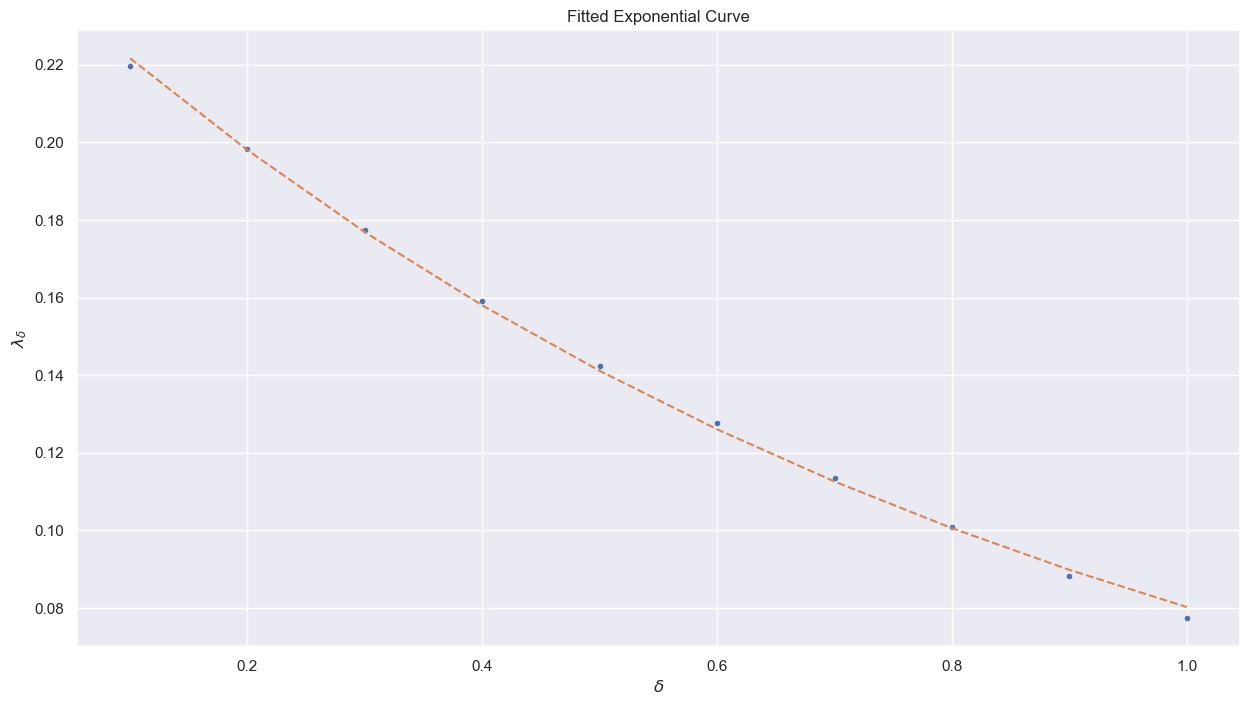

In [59]:
plt.figure(figsize=(15,8))
plt.plot(np.array(lambdas.index), np.array(lambdas['lambda_delta'].values), '.', label="data")
plt.plot(np.array(lambdas.index), exp_fit(np.array(lambdas.index), A, k), '--', label="fitted")
plt.title("Fitted Exponential Curve")
plt.xlabel('$\delta$')
plt.ylabel('$\lambda_\delta$')
plt.show()

From here, we now have our estimates for $A$ and $k$:

In [60]:
A, k

(0.2481712650658922, 1.1294000883986937)

Now, let's extend this to every day in our universe:

In [63]:
Alist = []
klist = []

for i in range(len(list_of_dates)-1):
    day = list_of_dates[i].strftime('%Y-%m-%d')
    print(day)
    
    sample = ETH_mid.loc[day]
    sample.index = pd.to_datetime(sample.index)
    
    mkt_sample = temp.loc[day][sample.index[0]:]['Price']
    
    deltadict = {}

    for price_delta in deltalist:
        sample['bid'] = sample['midpoint'] - price_delta
        sample['ask']  = sample['midpoint'] + price_delta

        bid_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) < sample.loc[x.name, 'bid']))


        ask_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask']))

        # Combine the two into a single signal
        limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

        deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

        deltadict[price_delta] = deltas
    
    lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
    
    paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas['lambda_delta'].values))
    A, k = paramsB
    
    Alist.append(A)
    klist.append(k)

2021-04-07
2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18


In [64]:
Alist

[0.2481712650658922,
 0.1303714983169198,
 0.0939984248174945,
 0.14840967742465133,
 0.09665473138759191,
 0.11717568832358817,
 0.18266446671327835,
 0.23521268578196547,
 0.21759856810206465,
 0.23026855883481376,
 0.15901001627341252,
 0.299793285637273]

In [65]:
klist

[1.1294000883986937,
 1.2927866589548886,
 1.5144070803332996,
 1.267950300144654,
 1.3040376533649602,
 1.5197167166479517,
 1.3363502327634356,
 1.0586172132032297,
 0.5579078807773586,
 1.1236843411141497,
 1.0902114098678555,
 0.5456407628799129]

In [66]:
# Save these because they took a long time to calculate
pd.DataFrame([Alist, klist], index=['Alist','Klist']).T.to_csv('./save/ETH_A_klist.csv')

In [99]:
A_klist = pd.read_csv('./save/ETH_A_klist.csv')
Alist = A_klist['Alist'].tolist()
klist = A_klist['Klist'].tolist()

#### 1.2.1.3 - Estimation of $\gamma$

Now that we have our estimates, we can put together a backtest for a single day, and use this backtest to calculate our gamma for the next day:

In [34]:
# Define next day
date = '2021-04-08'

# Get mid prices for next day
s = ETH_mid.loc[date]

# Fill in any missing seconds with NaNs
s = s.resample('S').asfreq(fill_value=np.nan)

# Forward fill the previous midprice if one doesn't
# exist for a given second-interval
s = s.ffill()
s = s['midpoint'] 

# Get market orders for next day
m = temp.loc[date]

In [38]:
# Use previous day's values, arbitrary gamma for now
sigma = sigmalist[0]
gamma = 0.1
A = Alist[0]
k = klist[0]

# Run a sample backtest
res = run_backtest(s, m, gamma, A, k, sigma)

In [39]:
# Save the PnL to a DataFrame
result = pd.DataFrame(res['pnl'][1:], index=s.index,columns=['PnL'])

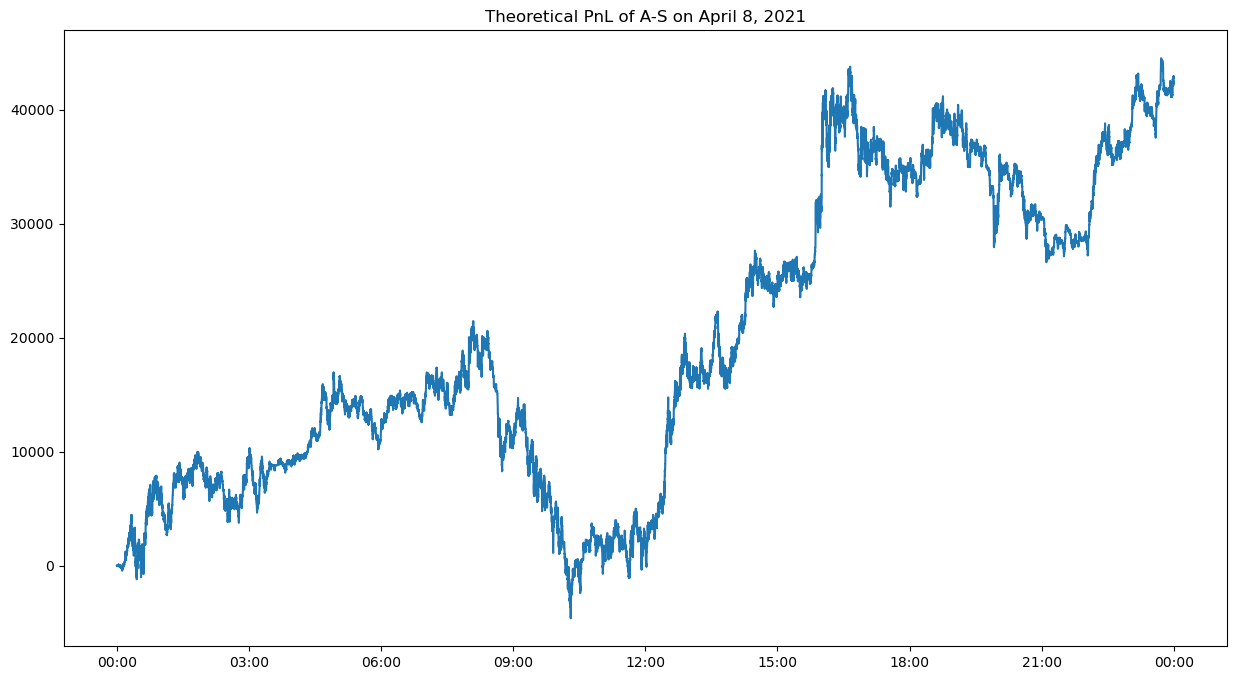

In [40]:
# Plot the PnL
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.title('Theoretical PnL of A-S on April 8, 2021')
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(result)
plt.show()

Looks good! Once we have a backtest completed, we can use the backtest to find an optimal risk-taking coefficient $\gamma$. Perhaps by selecting the gamma which optimizes our Sharpe ratio of the previous day, we can get a more attractive risk/return profile:

In [51]:
# Set up the function used to compute PnL using various gammas
# in parallel
def parallel_backtest(gamma):
    
    # Run the backtest
    res = run_backtest(s, m, gamma, A, k, sigma)
    
    # Calculate the percent change of PnL
    res_pnl = pd.Series(res['pnl']).pct_change().dropna()[1:]
    
    # Calculate the Sharpe of backtest
    return [gamma, res_pnl.mean() / res_pnl.std()] 

In [53]:
# Define number of processes
p = Pool(processes=20)

# Map the parallel_backtest function to each process,
# Define the gamma search space as 50 evenly-placed numbers
# between 0.1 and 5
data = p.map(parallel_backtest, np.linspace(0.1,5,50))

# End the processes
p.close()

In [54]:
best_gamma = pd.DataFrame(data).set_index(0).idxmax().values[0]
best_gamma

1.3000000000000003

Let's see if there is an obvious relationship between gamma and Sharpe:

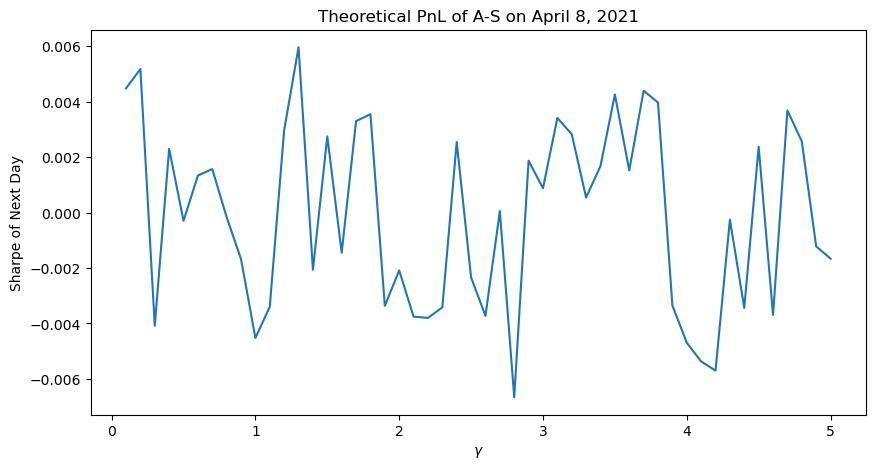

In [55]:
fig = plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)
plt.title('Theoretical PnL of A-S on April 8, 2021')
plt.plot(pd.DataFrame(data).set_index(0))
plt.xlabel('$\gamma$')
plt.ylabel('Sharpe of Next Day')
plt.show()

Unfortunately, there does not seem to be any sort of immediate relationship between gamma and Sharpe. If I had more computational power, I would definitely extend the search space. Perhaps then we could see a more obvious relationship? In any case, let's move on and see what the backtest of the next day looks like using our new gamma:

In [56]:
# The same values as before, just with a new gamma
res = run_backtest(s, m, best_gamma, A, k, sigma)

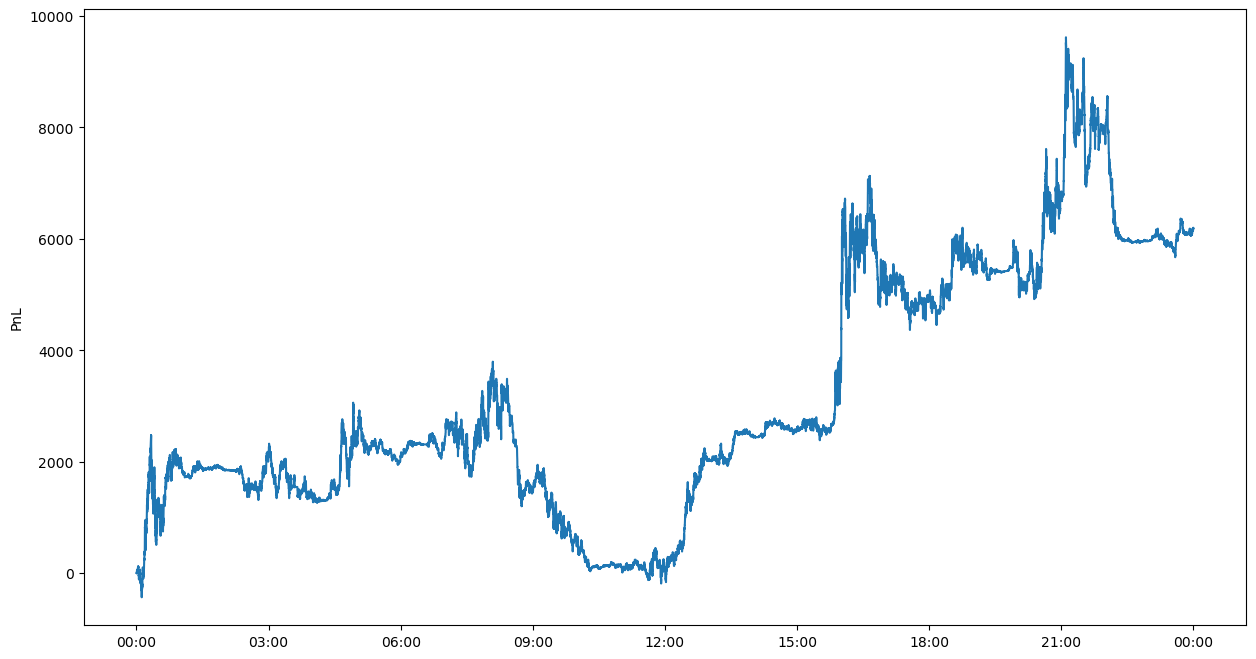

In [57]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.plot(pd.DataFrame(res['pnl'][1:], index=pd.to_datetime(s.index)))
plt.ylabel('PnL')
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.show()

Looks good! Now we can extend this idea to calculate the gammas for each day:

In [ ]:
gammalist = []

# Skip a day because we need to use parameter estimates from 
# day t-1 to calculate the PnL of t
for j in range(1,len(list_of_dates)):
    
    # Get parameters from previos day
    sigma = sigmalist[j-1]
    A = Alist[j-1]
    k = klist[j-1]
    
    date = list_of_dates[j].strftime('%Y-%m-%d')
    print(date)
    
    # Get mid prices for the day
    s = ETH_mid.loc[date]

    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint'] 
    
    m = temp.loc[date]

    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)
    
    p = Pool(processes=20)
    data = p.map(parallel_backtest, np.linspace(0.1,5,50))
    p.close()
    
    best_gamma = pd.DataFrame(data).set_index(0).idxmax().values[0]
    
    gammalist.append(best_gamma)

2021-04-08
2021-04-09
2021-04-10


In [ ]:
# Save gammalist so that we don't need to calculate it every time
pd.DataFrame(gammalist).to_csv('./save/ETH_gammalist.csv')

In [ ]:
gammalist = pd.read_csv('./save/ETH_gammalist.csv',header=None)[1][1:].tolist()
gammalist

### 1.2.2 Full Backtest

Now that we have all our parameters, we can run a full backtest on our data!


In [101]:
res = {}

# Exactly the same as before, just iterating through
# all the relevant days
for j in range(1,len(list_of_dates)-1):
    
    date = list_of_dates[j].strftime('%Y-%m-%d')
    s = ETH_mid.loc[date]
    
    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint'] 
    
    m = temp.loc[date]
    
    A = Alist[j-1]
    k = klist[j-1]
    sigma = sigmalist[j-1]
    gamma = gammalist[j-1]
    #print(gamma, A, k, sigma)
    
    res[date] = run_backtest(s, m, gamma, A, k, sigma)

In [102]:
# Save the results for later use
with open('./save/ETH_res.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
with open('./save/ETH_res.pickle', 'rb') as handle:
    res = pickle.load(handle)

Now, let's see the results of a full backtest! First we must combine the PnL streams such that the PnL of day $t+1$ starts off where day $t$ finished:

In [104]:
# Iterate through each day
for i in range(1,len(list_of_dates)-1):
    
    # Get both current day and previous day
    date = list_of_dates[i].strftime('%Y-%m-%d')
    prev_date = list_of_dates[i-1].strftime('%Y-%m-%d')
    
    # If first day, no addition needed
    if i == 1:
        res[date]['pnl'] = res[date]['pnl'][1:]
        
    # Else, add the terminal PnL of day t-1 to day t's PnL
    else:
        res[date]['pnl'] = res[date]['pnl'][1:]+res[prev_date]['pnl'][-1]

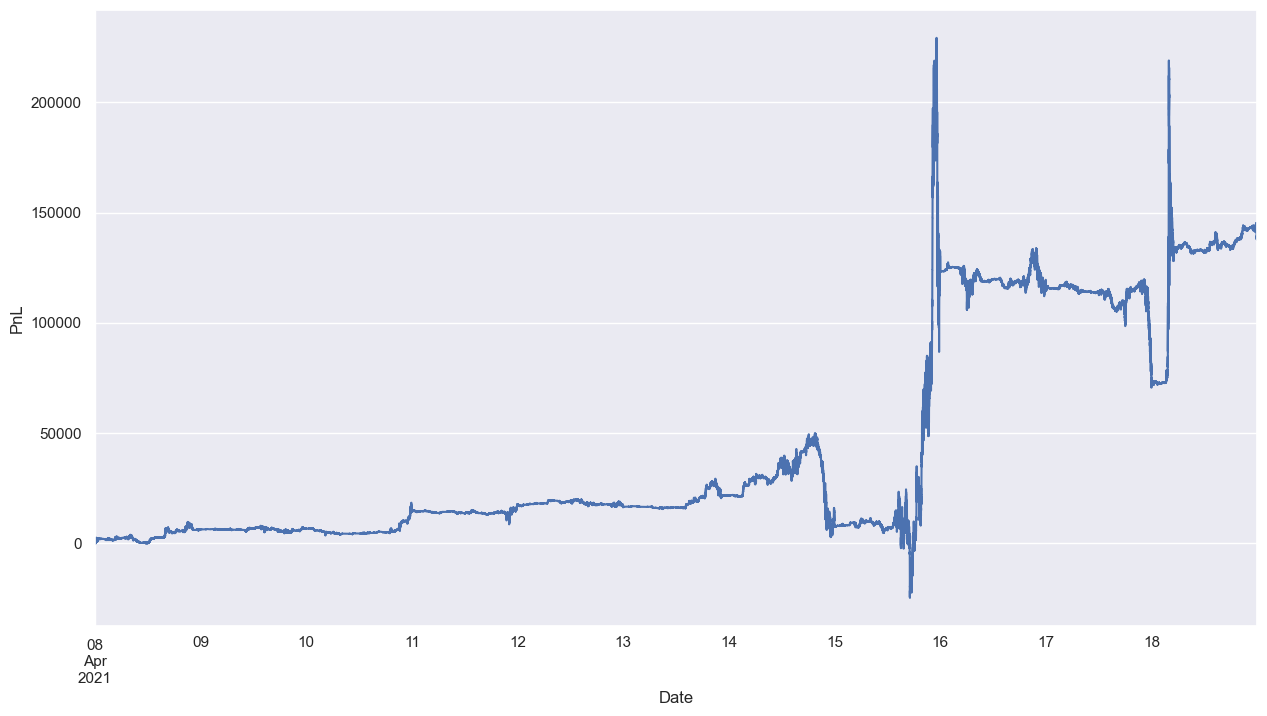

In [105]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)

# Concatenate into a single DataFrame
full_backtest_res = pd.concat([pd.Series(res[x]['pnl']) for x in res.keys()],
                              axis=0)

full_backtest_res.index = pd.to_datetime(ETH_mid['2021-04-08':'2021-04-18'].index)
full_backtest_res.plot()
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

# 2 - Cardano (ADA) 

Now that we've backtested the strategy on a very liquid token, let's move onto a less liquid token: Cardano (ADA). As of the writing of this notebook, ETH has a daily volume of \\$18 billion USD. ADA, on the other hand, has a daily volume of less than \\$2.5 billion. The difference in liquidity should result in different parameter estimates. 

## 2.1 - Data

### 2.1.1 - Kraken Market Data

Kraken offers market data on ADA as well, so the data cleaning process is the same as before:

In [109]:
temp = pd.read_csv('./ADAUSD.csv', header=None)

In [110]:
temp.columns = ['Timestamp', 'Price', 'Volume']

Now, let's look at each column individually to get a sense of how they are formatted/distributed:

In [111]:
# Look at dates first
dates = temp['Timestamp']

In [112]:
# Are there any NaNs? 
dates.isnull().sum()

0

In [113]:
temp['Timestamp'] = pd.to_datetime(temp['Timestamp'], unit='s')
temp.tail()

,Timestamp,Price,Volume
12146350,2023-09-30 23:47:15,0.253707,15.000000
12146351,2023-09-30 23:49:19,0.253964,15.000000
12146352,2023-09-30 23:50:43,0.253970,4752.407831
12146353,2023-09-30 23:52:03,0.253964,25.000000
12146354,2023-09-30 23:59:58,0.253971,77.585368


In [114]:
# Set timestamp as the index for the temp DataFrame
temp = temp.set_index('Timestamp')
temp.tail()

,Price,Volume
Timestamp,,
2023-09-30 23:47:15,0.253707,15.000000
2023-09-30 23:49:19,0.253964,15.000000
2023-09-30 23:50:43,0.253970,4752.407831
2023-09-30 23:52:03,0.253964,25.000000
2023-09-30 23:59:58,0.253971,77.585368


In [115]:
# Check that prices make sense
pd.DataFrame(temp['Price'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Price,12146355.0,1.127622,0.731245,0.01854,0.445363,1.15,1.565364,3.09778


In [116]:
# Check that volume makes sense
pd.DataFrame(temp['Volume'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Volume,12146355.0,2259.004178,8335.049314,1.000000e-08,36.45284,308.039691,1754.373284,1565680.0


### 2.1.2 Order Book Data

The dataset that contains ETH order book data also contains order book data for ADA. Let's take a look:

In [117]:
ADA_mid = pd.read_csv('./ADA_1sec.csv')
ADA_mid.head()

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:33:00.055697+00:00,1.17075,0.0015,0.000000,0.0000,-0.000641,-0.000726,-0.000811,-0.000897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:33:01.055697+00:00,1.17005,0.0001,684.618694,74178.0000,-0.000043,-0.000128,-0.000214,-0.000470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:33:02.055697+00:00,1.17045,0.0009,1280.056786,1835.7300,-0.000384,-0.000470,-0.000555,-0.000641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:33:03.055697+00:00,1.17005,0.0001,5.487769,1111.9329,-0.000043,-0.000128,-0.000214,-0.000470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:33:04.055697+00:00,1.17005,0.0001,683.701131,712.8927,-0.000043,-0.000128,-0.000214,-0.000470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
ADA_mid['system_time'] = pd.to_datetime(ADA_mid['system_time'])
ADA_mid = ADA_mid.loc[:,['system_time', 'midpoint']]

In [119]:
list_of_dates = ADA_mid['system_time'].dt.date.unique().tolist()

In [120]:
ADA_mid = ADA_mid.set_index('system_time')
ADA_mid.head()

,midpoint
system_time,
2021-04-07 11:33:00.055697+00:00,1.17075
2021-04-07 11:33:01.055697+00:00,1.17005
2021-04-07 11:33:02.055697+00:00,1.17045
2021-04-07 11:33:03.055697+00:00,1.17005
2021-04-07 11:33:04.055697+00:00,1.17005


In [121]:
# Remove milliseconds
ADA_mid.index = pd.to_datetime(ADA_mid.index.strftime('%Y-%m-%d %H:%M:%S'))
ADA_mid.head()

,midpoint
system_time,
2021-04-07 11:33:00,1.17075
2021-04-07 11:33:01,1.17005
2021-04-07 11:33:02,1.17045
2021-04-07 11:33:03,1.17005
2021-04-07 11:33:04,1.17005


In [122]:
# Convert index to datetime
dates = pd.to_datetime(ADA_mid.index) 

In [123]:
# Check if there are any missing seconds
len(ADA_mid) == len(ADA_mid.resample('S').asfreq())

False

In [124]:
# Fill in the gaps with the previous value
ADA_mid = ADA_mid.resample('S').ffill()

## 2.2 - Implementation of A-S to Cardano Data

The implementation to Cardano is extremely similar,, however we will need to change our units to reflect a similar value to 0.1ETH. Instead, we will trade 100ADA per transaction to get relatively close to the same position sizes as our ETH backtests. 

In [125]:
def run_backtest(s, m, gamma, A, k, sigma):
    
    N = 60*60*24
    T = 1
    dt = T/N

    # Initialize empty array for pnl
    pnl = np.zeros(N+1)

    # Inventory
    q = np.zeros(N+1)

    # Capital
    x = np.zeros(N+1)
    
    # Spread
    spr = np.zeros(N+1)

    # Ask limit orders
    r_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)

    # Bid limit orders
    r_b = np.zeros(N+1)
     
    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)

    # Iterate through each second
    for i in range(len(s)):
        
        # Find the date for the given iteration
        date = s.index[i]
        
        # Calculate our reservation price
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
        
        # Calculate our spread
        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        spr[i] = spread
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])
    
        # Define the distance between r[i] and our limit orders
        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap
            
        # Define our limit orders
        r_a[i] = r[i] + spread#delta_a
        r_b[i] = r[i] - spread#delta_b
        
        # Do not buy or sell unless we get a feasible market order
        sell = 0
        buy  = 0

        # If a market order is higher than our ask price, sell 0.1 units
        if hi_mkt.loc[:,'Price'].values[i] > r_a[i]:
            sell = 1

        # If a market order is lower than our bid price, buy 0.1 units
        if low_mkt.loc[:,'Price'].values[i] < r_b[i]:
            buy = 1

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        #     # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+spread) - buy*(s[i]-spread)

        #     # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    return {'pnl':pnl, 'x':x, 'q':q, 'spread':spr, 'r':r, 'r_a':r_a, 'r_b':r_b}

### 2.2.1 -  Parameter Estimation Methodology

Now, we can move onto estimating parameters. The methodology will be the same as before, but since we have lower volume, we should get different results!

In [126]:
day = '2021-04-07'
temp.loc[day]

,Price,Volume
Timestamp,,
2021-04-07 00:00:10,1.253499,48.129367
2021-04-07 00:00:15,1.255000,2758.543009
2021-04-07 00:00:15,1.254999,997.406727
2021-04-07 00:00:15,1.254999,2.586533
2021-04-07 00:00:15,1.254999,0.006708
...,...,...
2021-04-07 23:59:22,1.173918,1000.000000
2021-04-07 23:59:28,1.174015,2126.000000
2021-04-07 23:59:28,1.174127,5874.000000


#### 2.2.1.1 Estimation of Volatility, $\sigma$

In [127]:
# Calculate the stds
std = (np.log(temp.loc[:,'Price']).diff() # Difference the log prices
                                  .dropna() # Remove any NaNs
                                  .groupby(pd.Grouper(freq='1D')).std() # Calculate the std for each day
                                  .rolling('7D').mean()) # Compute the rolling 7-D average of these

# Scale accordingly
std = std * np.sqrt(60*60*24)
std

Timestamp
2018-09-28    22.712742
2018-09-29    12.859402
2018-09-30     9.105975
2018-10-01     7.531919
2018-10-02     6.174170
                ...    
2023-09-26     0.123426
2023-09-27     0.116951
2023-09-28     0.112995
2023-09-29     0.112971
2023-09-30     0.112718
Freq: D, Name: Price, Length: 1829, dtype: float64

In [128]:
sigmalist = [std[x.strftime('%Y-%m-%d')] for x in list_of_dates]

In [129]:
sigmalist

[0.11344984332883631,
 0.11544071712472877,
 0.11213090448089476,
 0.11229713863070315,
 0.11511638018858042,
 0.11672844309955786,
 0.10935046486313948,
 0.11378690148038605,
 0.11771539817394225,
 0.1417338115202713,
 0.14514759156183185,
 0.2168678415873047,
 0.22274526890481006]

In [130]:
# Save as .csv
pd.DataFrame(sigmalist).to_csv('./save/ADA_sigmalist.csv')

In [132]:
sigmalist=pd.read_csv('./save/ADA_sigmalist.csv', header=None)[1][1:].tolist()
sigmalist

[0.1134498433288363,
 0.1154407171247287,
 0.1121309044808947,
 0.1122971386307031,
 0.1151163801885804,
 0.1167284430995578,
 0.1093504648631394,
 0.113786901480386,
 0.1177153981739422,
 0.1417338115202713,
 0.1451475915618318,
 0.2168678415873047,
 0.22274526890481]

Since the order book is less liquid, the standard deviation of price differences is way higher! 

#### 2.2.1.2 Estimation of $A$ and $k$

The difference here is that we need to also adjust our $\delta$ distances--let's change them by a few orders of magnitude to reflect the difference in price magnitudes:

In [133]:
deltalist = np.linspace(0.0001,0.001,10)
deltalist

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ])

In [134]:
sample = ADA_mid.loc[day]
sample.index = pd.to_datetime(sample.index)
sample

,midpoint
system_time,
2021-04-07 11:33:00,1.17075
2021-04-07 11:33:01,1.17005
2021-04-07 11:33:02,1.17045
2021-04-07 11:33:03,1.17005
2021-04-07 11:33:04,1.17005
...,...
2021-04-07 23:59:55,1.17380
2021-04-07 23:59:56,1.17390
2021-04-07 23:59:57,1.17415


In [137]:
Alist = []
klist = []

for i in range(len(list_of_dates)-1):
    day = list_of_dates[i].strftime('%Y-%m-%d')
    print(day)
    
    sample = ADA_mid.loc[day]
    sample.index = pd.to_datetime(sample.index)
    
    mkt_sample = temp.loc[day][sample.index[0]:]['Price']
    
    deltadict = {}

    for price_delta in deltalist:
        sample['bid'] = sample['midpoint'] - price_delta
        sample['ask']  = sample['midpoint'] + price_delta

        bid_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) < sample.loc[x.name, 'bid']))


        ask_limit_order_hit = (mkt_sample.groupby(pd.Grouper(freq='1S'))
                                         .apply(lambda x: np.max(x) > sample.loc[x.name, 'ask']))

        # Combine the two into a single signal
        limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

        deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

        deltadict[price_delta] = deltas
    
    lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
    
    paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas['lambda_delta'].values))
    A, k = paramsB
    
    Alist.append(A)
    klist.append(k)

2021-04-07
2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18


In [145]:
pd.DataFrame([Alist, klist], index=['Alist','Klist']).T.to_csv('./save/ADA_A_klist.csv')

In [146]:
Alist = pd.read_csv('./save/ADA_A_klist.csv')['Alist'].tolist()
klist = pd.read_csv('./save/ADA_A_klist.csv')['Klist'].tolist()

In [147]:
klist

[1611.4918623915546,
 1366.5695441932958,
 1281.6570244868744,
 1355.3659251363454,
 915.6321686998286,
 1094.1879832086995,
 839.1880116459546,
 698.2011786842905,
 658.7301931677268,
 848.7276720741434,
 962.1297755886242,
 279.12600383420704]

#### 2.2.1.3 - Estimation of $\gamma$

Once we have a backtest completed, we can use the backtest to find an optimal risk-taking coefficient $\gamma$. Perhaps by selecting the gamma which optimizes our Sharpe ratio of the previous day, we can get a more attractive risk/return profile:

In [148]:
def parallel_backtest(gamma):
    res = run_backtest(s, m, gamma, A, k, sigma)
    res_pnl = pd.Series(res['pnl']).pct_change().dropna()[1:]
    return [gamma, res_pnl.mean() / res_pnl.std()] 

Now we can calculate the gammas for each day:

In [149]:
gammalist = []

# Skip a day because we need to use parameter estimates from 
# day t-1 to calculate the PnL of t
for j in range(1,len(list_of_dates)-1):
    
    # Get parameters from previos day
    sigma = sigmalist[j-1]
    A = Alist[j-1]
    k = klist[j-1]
    
    date = list_of_dates[j].strftime('%Y-%m-%d')
    print(date)
    
    # Get mid prices for the day
    s = ADA_mid.loc[date]

    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint'] 
    
    m = temp.loc[date]

    # Get market orders for next day, low market is lowest
    # price of market order submitted in 1-sec
    low_mkt = m.resample('S').min().reindex(s.index)

    # hi market is highest price of market order submitted
    # in 1-sec
    hi_mkt = m.resample('S').max().reindex(s.index)
    
    p = Pool(processes=20)
    data = p.map(parallel_backtest, np.linspace(0.1,1,10))
    p.close()
    
    best_gamma = pd.DataFrame(data).set_index(0).idxmax().values[0]
    
    gammalist.append(best_gamma)

2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18


In [150]:
pd.DataFrame(gammalist).to_csv('./save/ADA_gammalist.csv')

In [151]:
gammalist = pd.read_csv('./save/ADA_gammalist.csv', header=None)[1][1:].tolist()

In [152]:
gammalist

[0.3, 1.0, 1.0, 0.9, 0.2, 0.1, 0.3, 1.0, 0.2, 0.1, 0.5]

### 2.2.2 Full Backtest

Now that we have all our parameters, we can run a full backtest on our data!


In [153]:
res = {}
for j in range(1,len(list_of_dates)-1):
    
    date = list_of_dates[j].strftime('%Y-%m-%d')
    s = ADA_mid.loc[date]
    
    # Fill in any missing seconds with NaNs
    s = s.resample('S').asfreq(fill_value=np.nan)

    # Forward fill the previous midprice if one doesn't
    # exist for a given second-interval
    s = s.ffill()
    s = s['midpoint'] 
    
    m = temp.loc[date]
    
    A = Alist[j-1]
    k = klist[j-1]
    sigma = sigmalist[j-1]
    gamma = gammalist[j-1]
    #print(gamma, A, k, sigma)
    
    res[date] = run_backtest(s, m, gamma, A, k, sigma)

In [154]:
with open('ADA_res.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [155]:
with open('ADA_res.pickle', 'rb') as handle:
    res = pickle.load(handle)

In [156]:
# Iterate through each day
for i in range(1,len(list_of_dates)-1):
    
    # Get both current day and previous day
    date = list_of_dates[i].strftime('%Y-%m-%d')
    prev_date = list_of_dates[i-1].strftime('%Y-%m-%d')
    
    # If first day, no addition needed
    if i == 1:
        res[date]['pnl'] = res[date]['pnl'][1:]
        
    # Else, add the terminal PnL of day t-1 to day t's PnL
    else:
        res[date]['pnl'] = res[date]['pnl'][1:]+res[prev_date]['pnl'][-1]

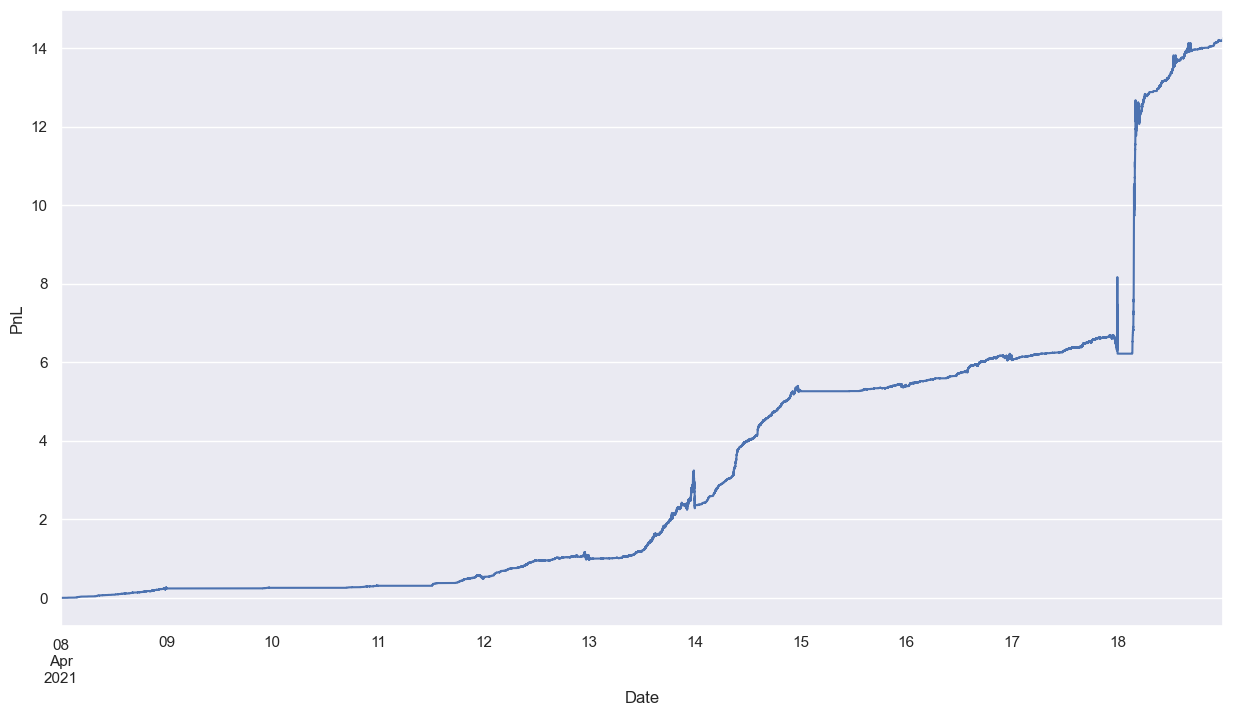

In [157]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)

# Concatenate into a single DataFrame
full_backtest_res = pd.concat([pd.Series(res[x]['pnl']) for x in res.keys()],
                              axis=0)

full_backtest_res.index = pd.to_datetime(ETH_mid['2021-04-08':'2021-04-18'].index)
full_backtest_res.plot()
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

# Comparison of Strategies 

Now, let's take a look at the outcomes of each of the strategies to compare and contrast:

In [158]:
# Get list of dates
list_of_dates = pd.to_datetime(['2021-4-'+str(x) for x in range(7,20)]).date
list_of_dates = [x.strftime('%Y-%m-%d') for x in list_of_dates ]

# Use this for indices 
date_index = ETH_mid['2021-04-08':'2021-04-18'].index

In [159]:
# ETH
with open('./save/ETH_res.pickle', 'rb') as handle:
    ETH_res = pickle.load(handle)
    
ETH_sigmalist = pd.read_csv('./save/ETH_sigmalist.csv').values.tolist()
ETH_Alist = pd.read_csv('./save/ETH_A_Klist.csv')['Alist'].values.tolist()
ETH_klist = pd.read_csv('./save/ETH_A_Klist.csv')['Klist'].values.tolist()
ETH_gammalist = pd.read_csv('./save/ETH_gammalist.csv').values.tolist()

for i in range(1, len(list_of_dates)-1):
    date = list_of_dates[i]
    prev_date = list_of_dates[i-1]    
    if i == 1:
        ETH_res[date]['pnl'] = ETH_res[date]['pnl'][1:]
    else:
        ETH_res[date]['pnl'] = ETH_res[date]['pnl'][1:]+ETH_res[prev_date]['pnl'][-1]
        
ETH_tot_pnl = pd.concat([pd.Series(ETH_res[date]['pnl']) for date in ETH_res.keys()],
                        axis=0)
ETH_tot_pnl.index = date_index


# ADA
with open('ADA_res.pickle', 'rb') as handle:
    ADA_res = pickle.load(handle)
    
ADA_sigmalist = pd.read_csv('./save/ADA_sigmalist.csv').values.tolist()
ADA_Alist = pd.read_csv('./save/ADA_A_Klist.csv')['Alist'].values.tolist()
ADA_klist = pd.read_csv('./save/ADA_A_Klist.csv')['Klist'].values.tolist()
ADA_gammalist = pd.read_csv('./save/ADA_gammalist.csv').values.tolist()

for i in range(1, len(list_of_dates)-1):
    date = list_of_dates[i]
    prev_date = list_of_dates[i-1]    
    if i == 1:
        ADA_res[date]['pnl'] = ADA_res[date]['pnl'][1:]
    else:
        ADA_res[date]['pnl'] = ADA_res[date]['pnl'][1:]+ADA_res[prev_date]['pnl'][-1]
        
ADA_tot_pnl = pd.concat([pd.Series(ADA_res[date]['pnl']) for date in ADA_res.keys()],
                        axis=0)
ADA_tot_pnl.index = date_index

Naturally, the most important part is the returns.

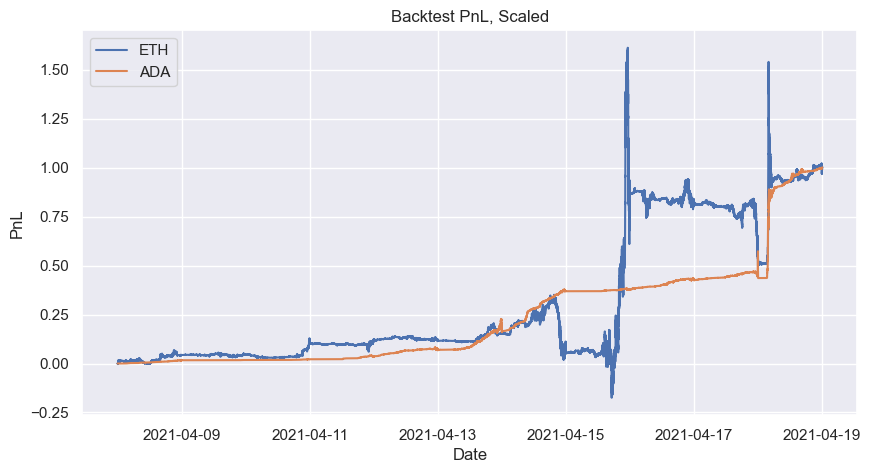

In [160]:
# Plot the results
fig = plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)
plt.plot(pd.DataFrame(ETH_tot_pnl) / ETH_tot_pnl.values[-1], label='ETH')
plt.plot(pd.DataFrame(ADA_tot_pnl) / ADA_tot_pnl.values[-1], label='ADA')
plt.legend()
plt.title('Backtest PnL, Scaled')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

The shape of these PnL curves does look strange indeed. I believe this has something to do with the price of inventory moving drastically. Next, let's take a look at the distribution of returns:

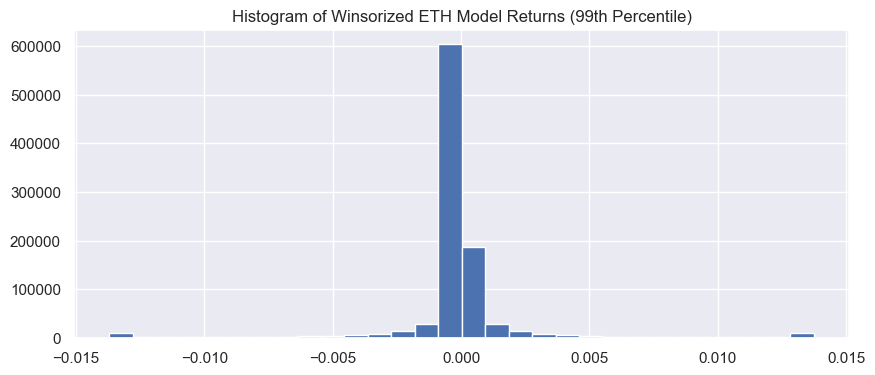

In [161]:
plt.figure(figsize=(10,4))
ETH_ret = ETH_tot_pnl.pct_change().replace(np.inf,np.nan).dropna()

# Winsorize for better visualizations
w_ETH_ret = ETH_ret.clip(lower=ETH_ret.quantile(0.01), upper=ETH_ret.quantile(0.99))
plt.title('Histogram of Winsorized ETH Model Returns (99th Percentile)')
plt.hist(w_ETH_ret, bins=30)
plt.show()

This histogram certainly has fat tails! It appears as though the fat tails are what's keeping the PnL positive--the largest bar in the histogram seems to be negative! Very interesting to see. Let's move onto Cardano:

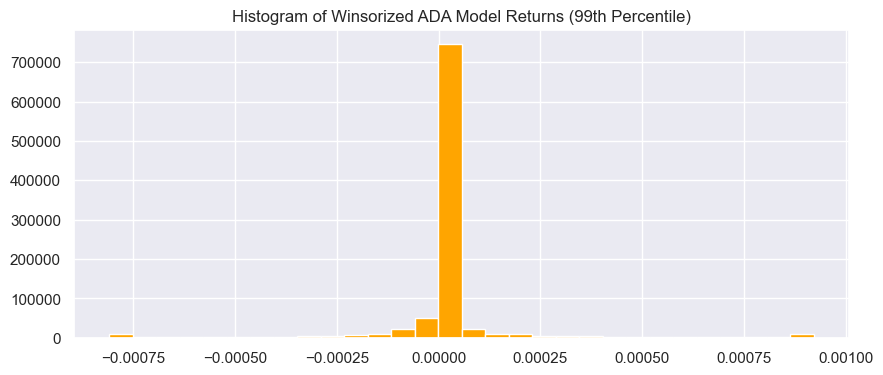

In [162]:
plt.figure(figsize=(10,4))
ADA_ret = ADA_tot_pnl.pct_change().replace(np.inf,np.nan).dropna()

# Winsorize for better visualizations
w_ADA_ret = ADA_ret.clip(lower=ADA_ret.quantile(0.01), upper=ADA_ret.quantile(0.99))
plt.title('Histogram of Winsorized ADA Model Returns (99th Percentile)')
plt.hist(w_ADA_ret, bins=30, color='orange')
plt.show()

Cardano also has fat tails. However, the largest bar this time appears to be positive, which is a good sign! 

Next, let's look at how the inventories vary:

In [163]:
ETH_q = pd.concat([pd.Series(ETH_res[date]['q'][1:]) for date in ETH_res.keys()], axis=0)
ETH_q.index = date_index

ADA_q = pd.concat([pd.Series(ADA_res[date]['q'][1:]) for date in ADA_res.keys()], axis=0)
ADA_q.index = date_index

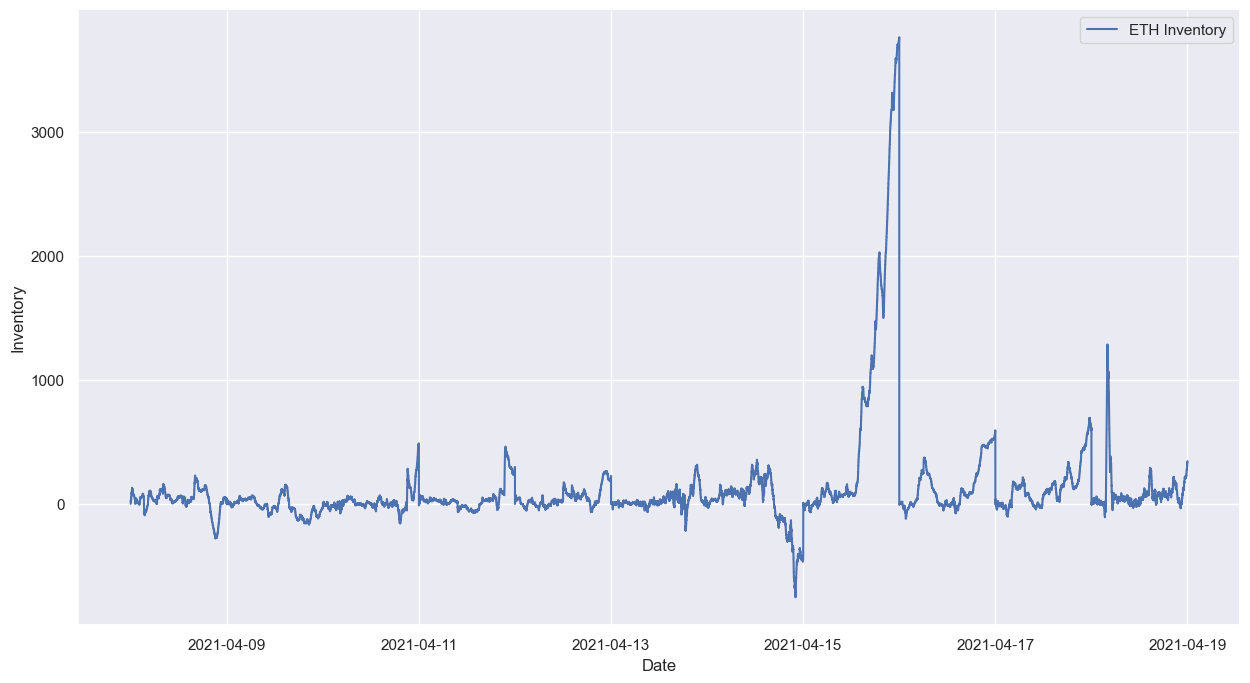

In [164]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.plot(ETH_q, label='ETH Inventory')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.legend()
plt.show()

We can clearly see here that the massive rise in inventory happens when there is a huge change in PnL as well. This is something I would need to fix for an improved implementation of the model

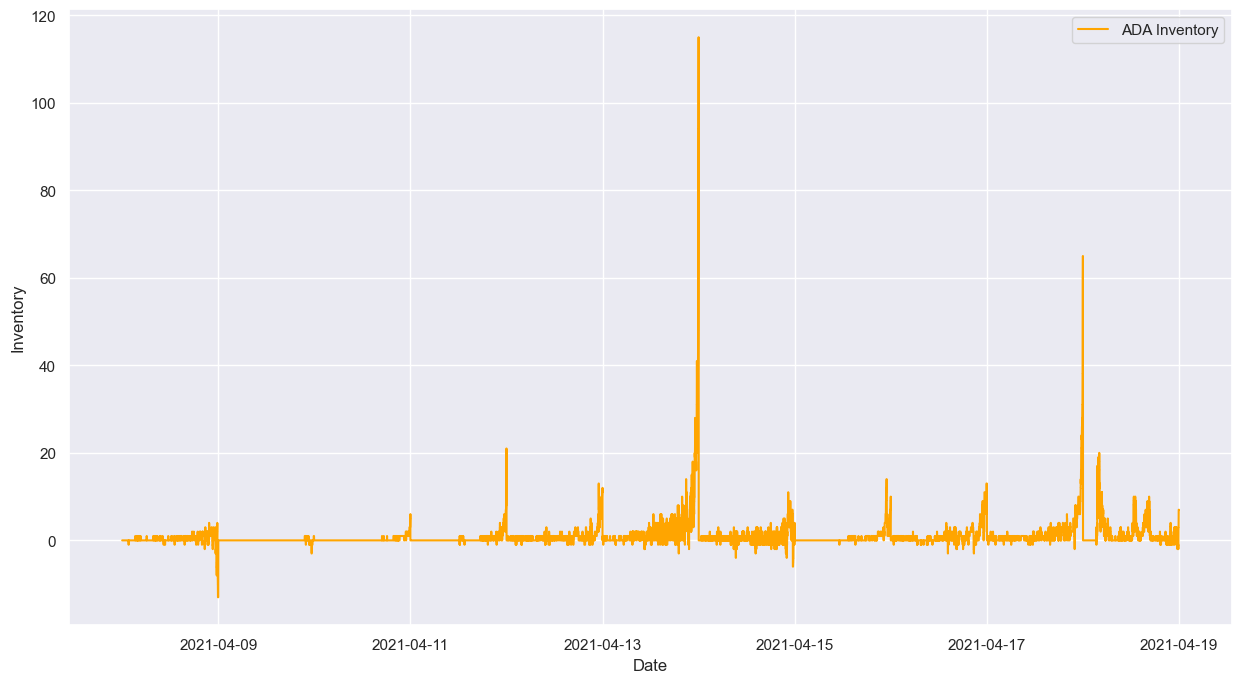

In [165]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.plot(ADA_q, label='ADA Inventory', color='orange')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.legend()
plt.show()

It is likewise the case here. The PnL would look far more normal if we were able to control for maximum inventory. This is outlined in the paper along with the infinite horizon strategy, but I did not have enough time to add in that part. Let's take a deep-dive into a single asset's day to see exactly how it works:

In [166]:
# Get mid data
day_mid = ETH_mid['2021-04-12'][13000:13600]
day_mid.index = pd.to_datetime(day_mid.index)

# Get the mkt data
#day_mkt = pd.read_csv('ETH_mkt.csv').set_index('Timestamp')
#day_mkt.index = pd.to_datetime(day_mkt.index)
#day_mkt[day_mid.index[0]]
#day_mkt = day_mkt[ETH_mid.index]['Price']

day_sample = ETH_res['2021-04-12']
day_ra = pd.DataFrame(day_sample['r_a'][13000:13600], index = day_mid.index)
day_r  = pd.DataFrame(day_sample['r'][13000:13600], index = day_mid.index)
day_rb = pd.DataFrame(day_sample['r_b'][13000:13600], index = day_mid.index)

# Get inventory
day_q     = ETH_res['2021-04-12']['q'][13000:13600]
day_buys  = np.array(pd.Series(day_q).diff() < 0) * np.array(day_ra).T.tolist()[0]
day_buys = pd.DataFrame(day_buys, index = day_mid.index).replace(0, np.nan).dropna()

day_sells  = np.array(pd.Series(day_q).diff() > 0) * np.array(day_rb).T.tolist()[0]
day_sells = pd.DataFrame(day_sells, index = day_mid.index).replace(0, np.nan).dropna()

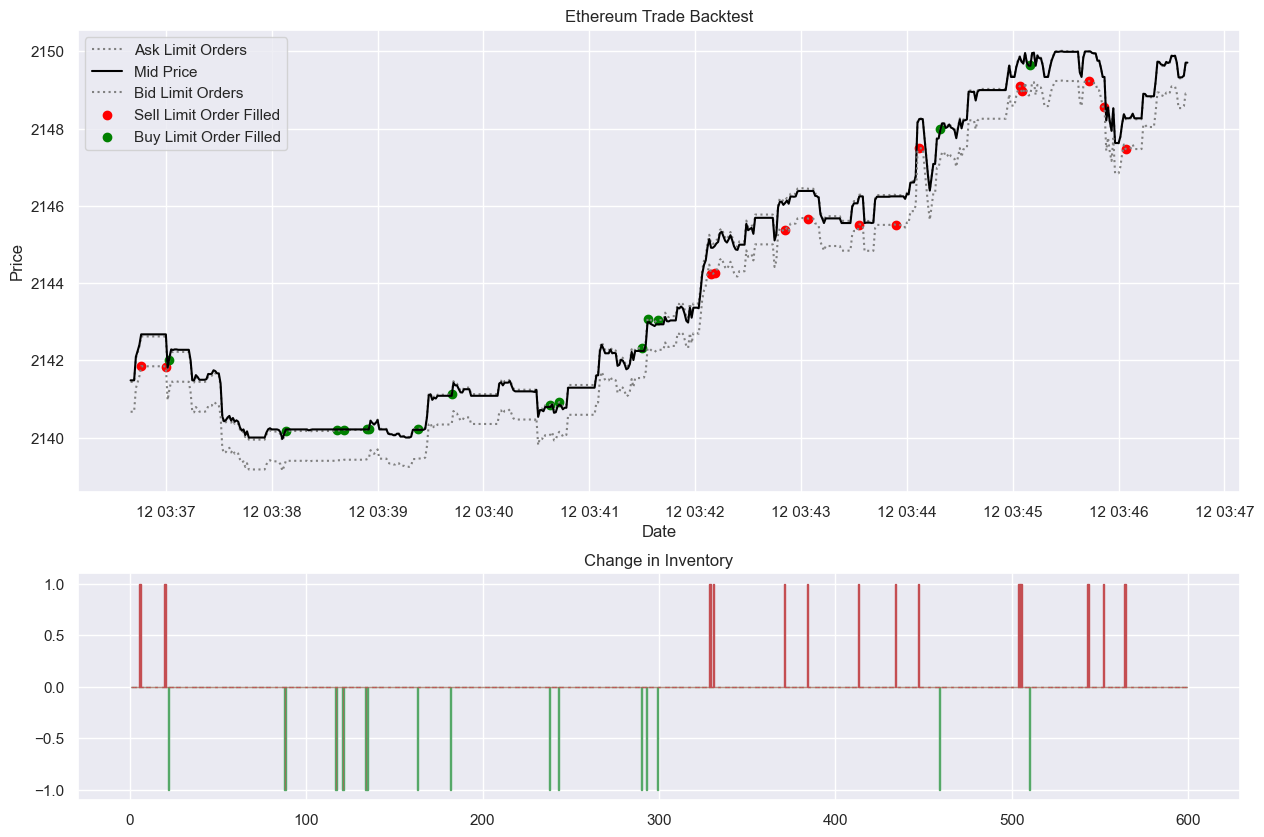

In [167]:
fig = plt.figure(figsize=(15,10))

spec = gridspec.GridSpec(ncols=1, nrows=2, wspace=0.5,
                         hspace=0.5, height_ratios=[3, 1])

fig.add_subplot(spec[0])

# Plot limit orders and mid price
plt.plot(day_ra, color='grey',  label='Ask Limit Orders', ls=':')
plt.plot(day_mid, color='black', label='Mid Price')
plt.plot(day_rb, color='grey',  label='Bid Limit Orders', ls=':')

# Add buys and sells
plt.scatter(pd.to_datetime(day_sells.index), day_sells.values, color='red', label='Sell Limit Order Filled')
plt.scatter(pd.to_datetime(day_buys.index), day_buys.values, color='green', label='Buy Limit Order Filled')

plt.legend()
plt.title('Ethereum Trade Backtest')

plt.xlabel('Date')
plt.ylabel('Price')

fig.add_subplot(spec[1])

plt.subplot(3,1,3)

plt.bar(range(len(day_q)), pd.Series(day_q).diff()*(pd.Series(day_q).diff()<0), color='r', edgecolor='g')
plt.bar(range(len(day_q)), pd.Series(day_q).diff()*(pd.Series(day_q).diff()>0), color='r', edgecolor='r')
plt.title('Change in Inventory')

plt.show()

Finally, let's look at the spreads:

In [168]:
ETH_spread = pd.concat([pd.Series(ETH_res[date]['spread'][:-1]) for date in ETH_res.keys()], axis=0)
ETH_spread.index = date_index

ADA_spread = pd.concat([pd.Series(ADA_res[date]['spread'][:-1]) for date in ADA_res.keys()], axis=0)
ADA_spread.index = date_index

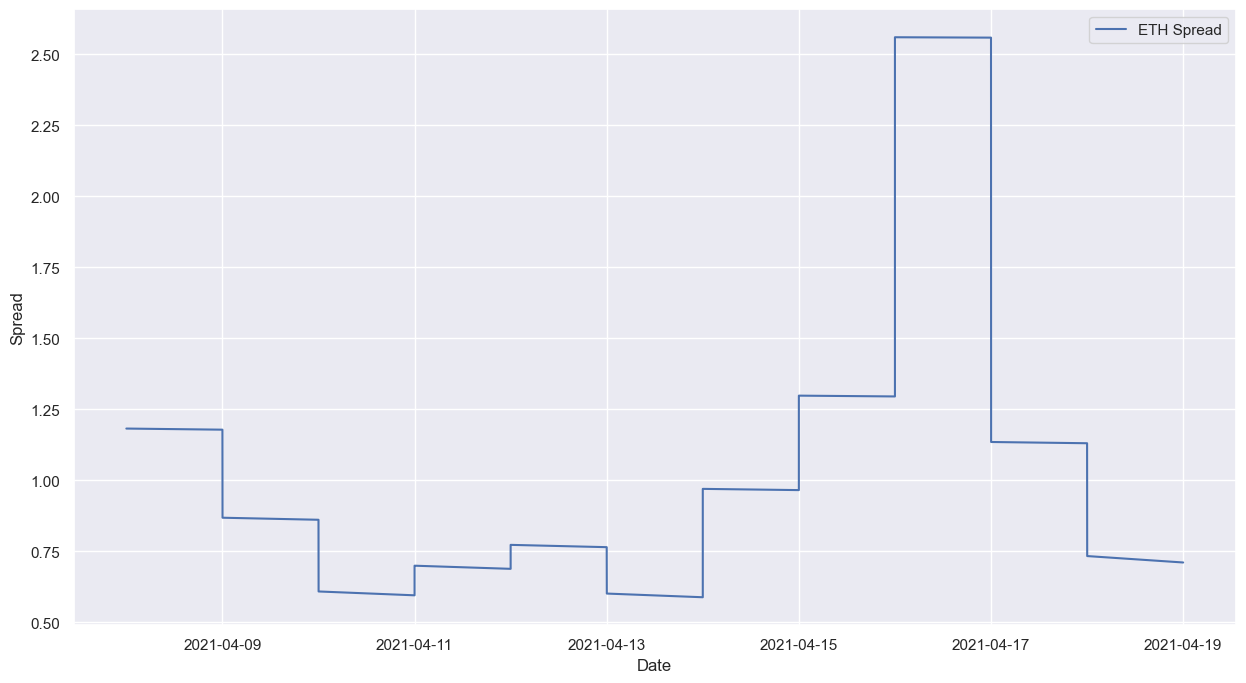

In [169]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.plot(ETH_spread, label='ETH Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

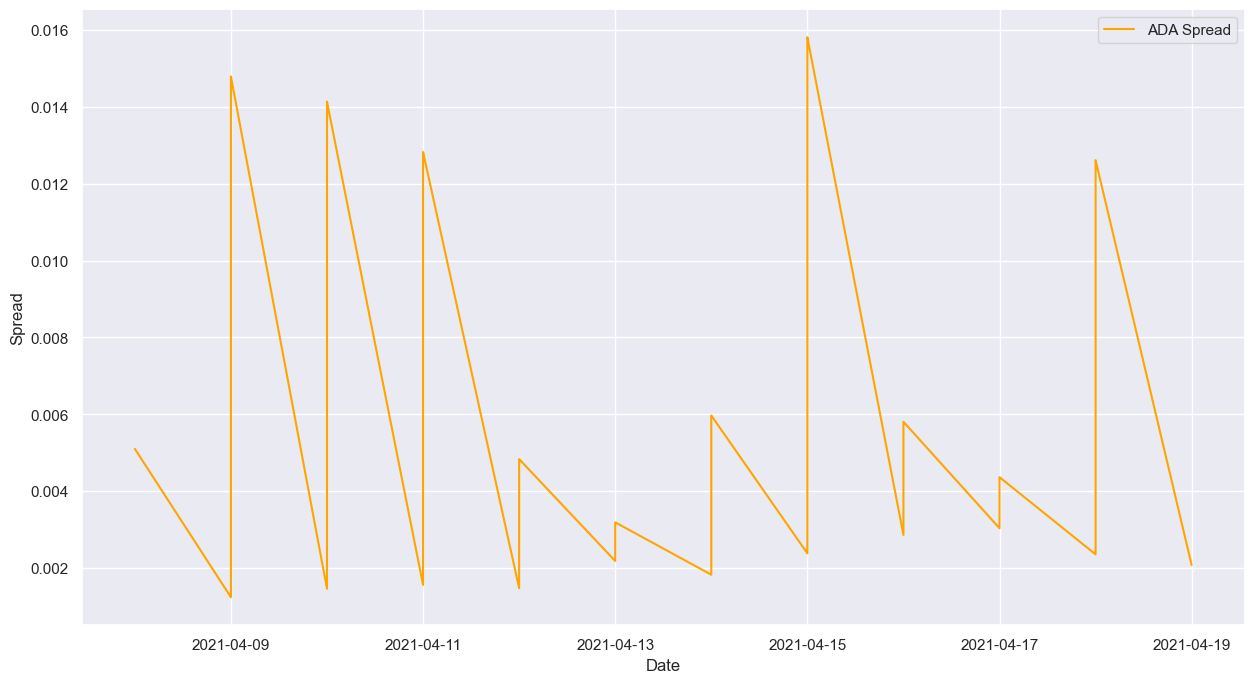

In [170]:
# Plot the results
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
plt.plot(ADA_spread, label='ADA Spread', color='orange')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

Wow, we can see that ADA's spread is extremely sensitive to time of day!